# **Trabalho Análise Preditiva Avançada**


**Equipe:**
* Ana Paula Gonçalves dos Santos
* Carlos Eduardo Ontiveros
* Hugo Crisóstomo
* Marcelo Costa
* Matheus Amaral
* Reginaldo Teodoro

## **1) Introdução**

O presente trabalho é requisito de avaliação da disciplina Análise Preditiva Avançada e compreende o desenvolvimento de um modelo de predição que classifique se a pessoa possui a doença da diabetes.

A base de dados utilizada e seu descritivo estão disponíveis em:
https://www.kaggle.com/uciml/pima-indians-diabetes-database.

De acordo com informações do site, esse conjunto de dados é originalmente do Instituto Nacional de Diabetes e Doenças Digestivas e Renais. O objetivo do conjunto de dados é prever com diagnóstico se um paciente tem diabetes ou não, com base em certas medidas diagnósticas incluídas no conjunto de dados. 

## **2) Selecionar e tratar dados de entrada e saída**

apagar no final - colei para não perder a sequência do que precisa ser feito

1 - carregar dataset
2- selecionar e tratar dados de entrada e saída
3 - separar conjunto de treino e teste
4 -normalizar os dados
5 - treinar os modelos
6 - avaliar os modelos
7 - definir o modelo mais robusto.

### **2.1) Importar as bibliotecas a serem utilizadas**

Instalando as bibliotecas a serem utilizadas

In [ ]:
!pip install pandas seaborn sklearn ppscore imbalanced-learn
!pip install tpot
!pip install catboost
!pip install scikit-optimize
!pip install ppscore

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import ppscore as pps
import json
import warnings
from tpot import TPOTClassifier

# Linear Methods
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

# Ensemble methods
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

# Multi layer perceptron
from sklearn.neural_network import MLPClassifier

# Suport Vector Machine
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, classification_report , confusion_matrix

from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import tqdm

In [ ]:
# Remove Warnig messages
warnings.simplefilter('ignore')

In [ ]:
sns.set_theme(color_codes = True)

### **2.2 Carregar o Dataset**



Carregando o arquivo diabetes.csv e verificando as primeiras linhas.

In [ ]:
df = pd.read_csv('diabetes.csv')

print(f'Shape: {df.shape}')

df.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **2.3 Análise Exploratória**

O dataset "diabetes" possui oito variáveis ​​preditoras e a variável dependente *Outcome*. 

Descrição das variáveis ​​preditoras:



1. Pregnancies: número de gestações que a paciente teve;
2. Glucose: concentração de glicose plasmática a 2 horas em um teste oral de tolerância à glicose;
3. BloodPressure: pressão arterial diastólica (mm Hg)
4. SkinThickness: espessura da dobra da pele do tríceps (mm);
5. Insulin: insulina sérica de 2 horas (mu U / ml);
6. BMI: índice de massa corporal (peso em kg / (altura em m) ^ 2);
7. DiabetesPedigreeFunction: função que pontua a probabilidade de diabetes com base no histórico familiar.
8. Age: idade da paciente.


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### **2.3.1 Tipo de Variável**
A exceção das variáveis *BMI* e *DiabetesPedigreeFunction*, que são números decimais, as demais são números inteiros.


In [ ]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

#### **2.3.2 Estatísticas Básicas**

In [ ]:
# Numeric and categorical features
num = df.select_dtypes(['int64', 'float64', 'uint8'])
cat = df.select_dtypes(['object'])

# Calculate State
aux = pd.DataFrame(
    {
        
        'type': df.dtypes,
        'missing values': df.isnull().sum(),
        'mean': num.mean(),
        'median': num.median(),
        'max': num.max(),
        'min': num.min(),
        '# Unique Values': df.nunique(),
        'STD': num.std(),
        'Skew': num.skew(),
        'Kurtosis': num.kurtosis()
           
    },
    index = df.columns)

aux

,type,missing values,mean,median,max,min,# Unique Values,STD,Skew,Kurtosis
Pregnancies,int64,0,3.845052,3.0000,17.00,0.000,17,3.369578,0.901674,0.159220
Glucose,int64,0,120.894531,117.0000,199.00,0.000,136,31.972618,0.173754,0.640780
BloodPressure,int64,0,69.105469,72.0000,122.00,0.000,47,19.355807,-1.843608,5.180157
SkinThickness,int64,0,20.536458,23.0000,99.00,0.000,51,15.952218,0.109372,-0.520072
Insulin,int64,0,79.799479,30.5000,846.00,0.000,186,115.244002,2.272251,7.214260
BMI,float64,0,31.992578,32.0000,67.10,0.000,248,7.884160,-0.428982,3.290443
DiabetesPedigreeFunction,float64,0,0.471876,0.3725,2.42,0.078,517,0.331329,1.919911,5.594954
Age,int64,0,33.240885,29.0000,81.00,21.000,52,11.760232,1.129597,0.643159
Outcome,int64,0,0.348958,0.0000,1.00,0.000,2,0.476951,0.635017,-1.600930


#### **2.3.3 Missing Values:** 
Não foram identificados valores ausentes. No entanto, em virtude da característica das variáveis, dados iguais a zero (exceto para Outcome e Pregnacies), foram considerados como ausentes. Isso porque o valor valor zero não faz sentido e impactaria o modelo de predição final.
Dessa forma, optou-se por substituí-lo pela média calculada, considerando os demais valores da mesma variável.

In [ ]:
# Verifica se existem valores nulos nas variáveis
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
# Verifica se existem valores ausentes nas variáveis
pd.isna(df).sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
# Verifica a ocorrência de valores zeros nas variáveis independentes
for var in df.drop(['Outcome'], axis = 1):
    df_temp = pd.DataFrame(df[var])
    filtro = df_temp[var] == 0
    df_zeros = df_temp[filtro]
    print(df_zeros.count())
    print('-----')
    

Pregnancies    111
dtype: int64
-----
Glucose    5
dtype: int64
-----
BloodPressure    35
dtype: int64
-----
SkinThickness    227
dtype: int64
-----
Insulin    374
dtype: int64
-----
BMI    11
dtype: int64
-----
DiabetesPedigreeFunction    0
dtype: int64
-----
Age    0
dtype: int64
-----


##### **2.3.3.1 Tratar as variáveis com valor igual a zero** 

In [ ]:
# substitui valor zero pela média calculada considerando os demais valores
for var in df.drop(['Outcome','Pregnancies'], axis = 1):
    df[var] = df[var].replace([0],df[var].mean())

In [ ]:
# Verifica nova descrição/resumo dos dados após os ajustes
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### **2.3.4 Skewness**:  medida de simetria de dados da distribuição de probabilidade de uma variável. 

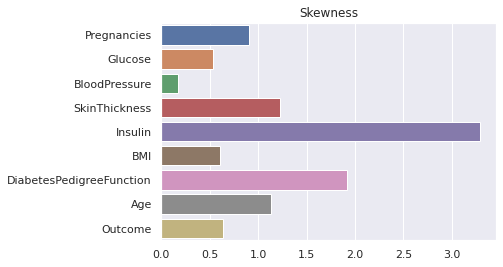

In [ ]:
plt.title('Skewness')

sns.barplot(x = df.skew(), y = df.columns)

plt.show()

#### **2.3.5 Kurtuosis**: medida de achatamento da distribuição dos dados. 

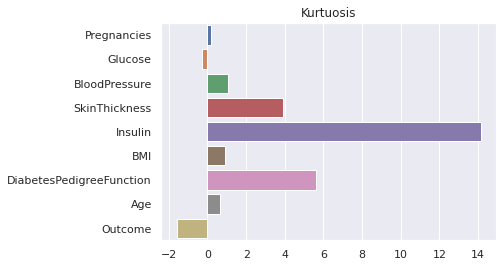

In [ ]:
plt.title('Kurtuosis')

sns.barplot(x = df.kurtosis(), y = df.columns)

plt.show()

#### **2.3.6 Gráficos**

##### Histograma

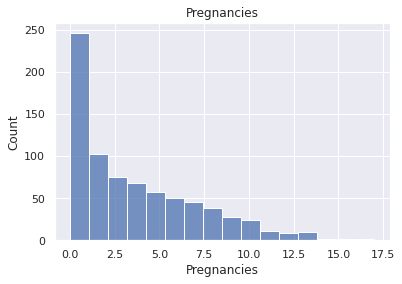

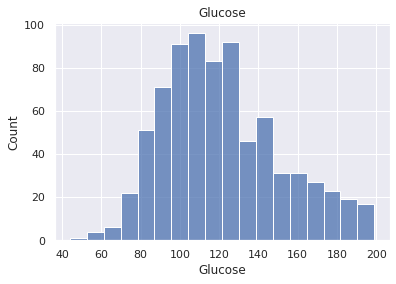

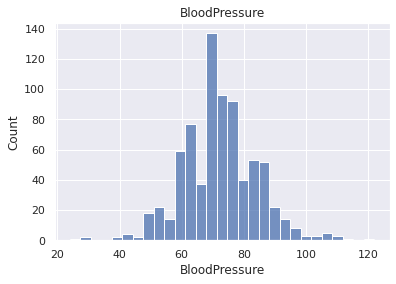

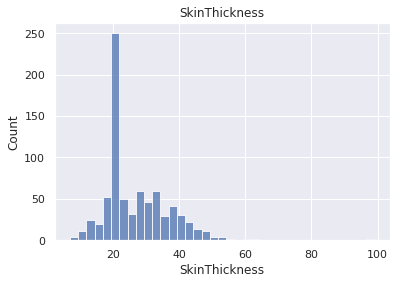

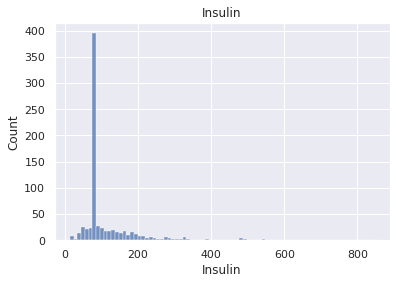

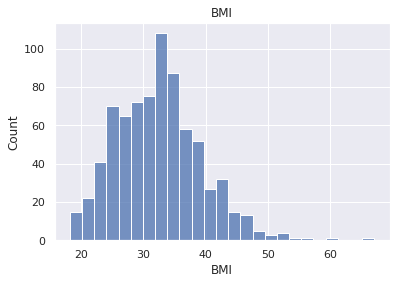

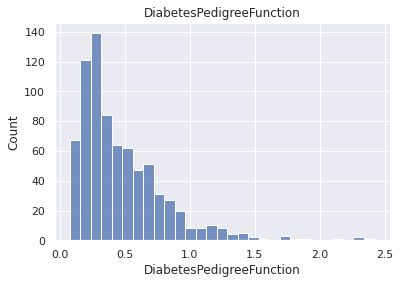

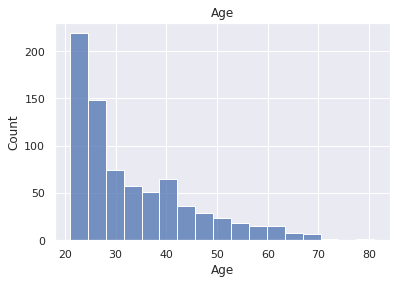

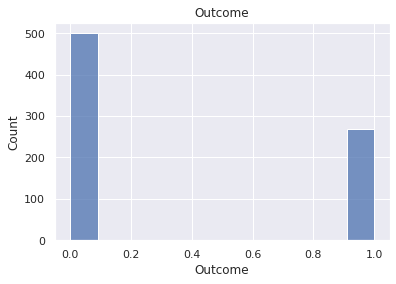

In [ ]:
for i in df.columns:
    
    #df[i].plot.hist()

    #sns.histplot(data = df, x = i, hue = 'Outcome', multiple='layer')
    sns.histplot(data = df, x = i, multiple='layer')
    plt.title(i)
    
    plt.show()

In [ ]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

##### Pairplot
Essa função analisa todos os dados de uma vez, plotando a distribuição de cada feature, bem como as relações entre pares de features.
É possível verificar as correlações de algumas variáveis, a exemplo da glicose.

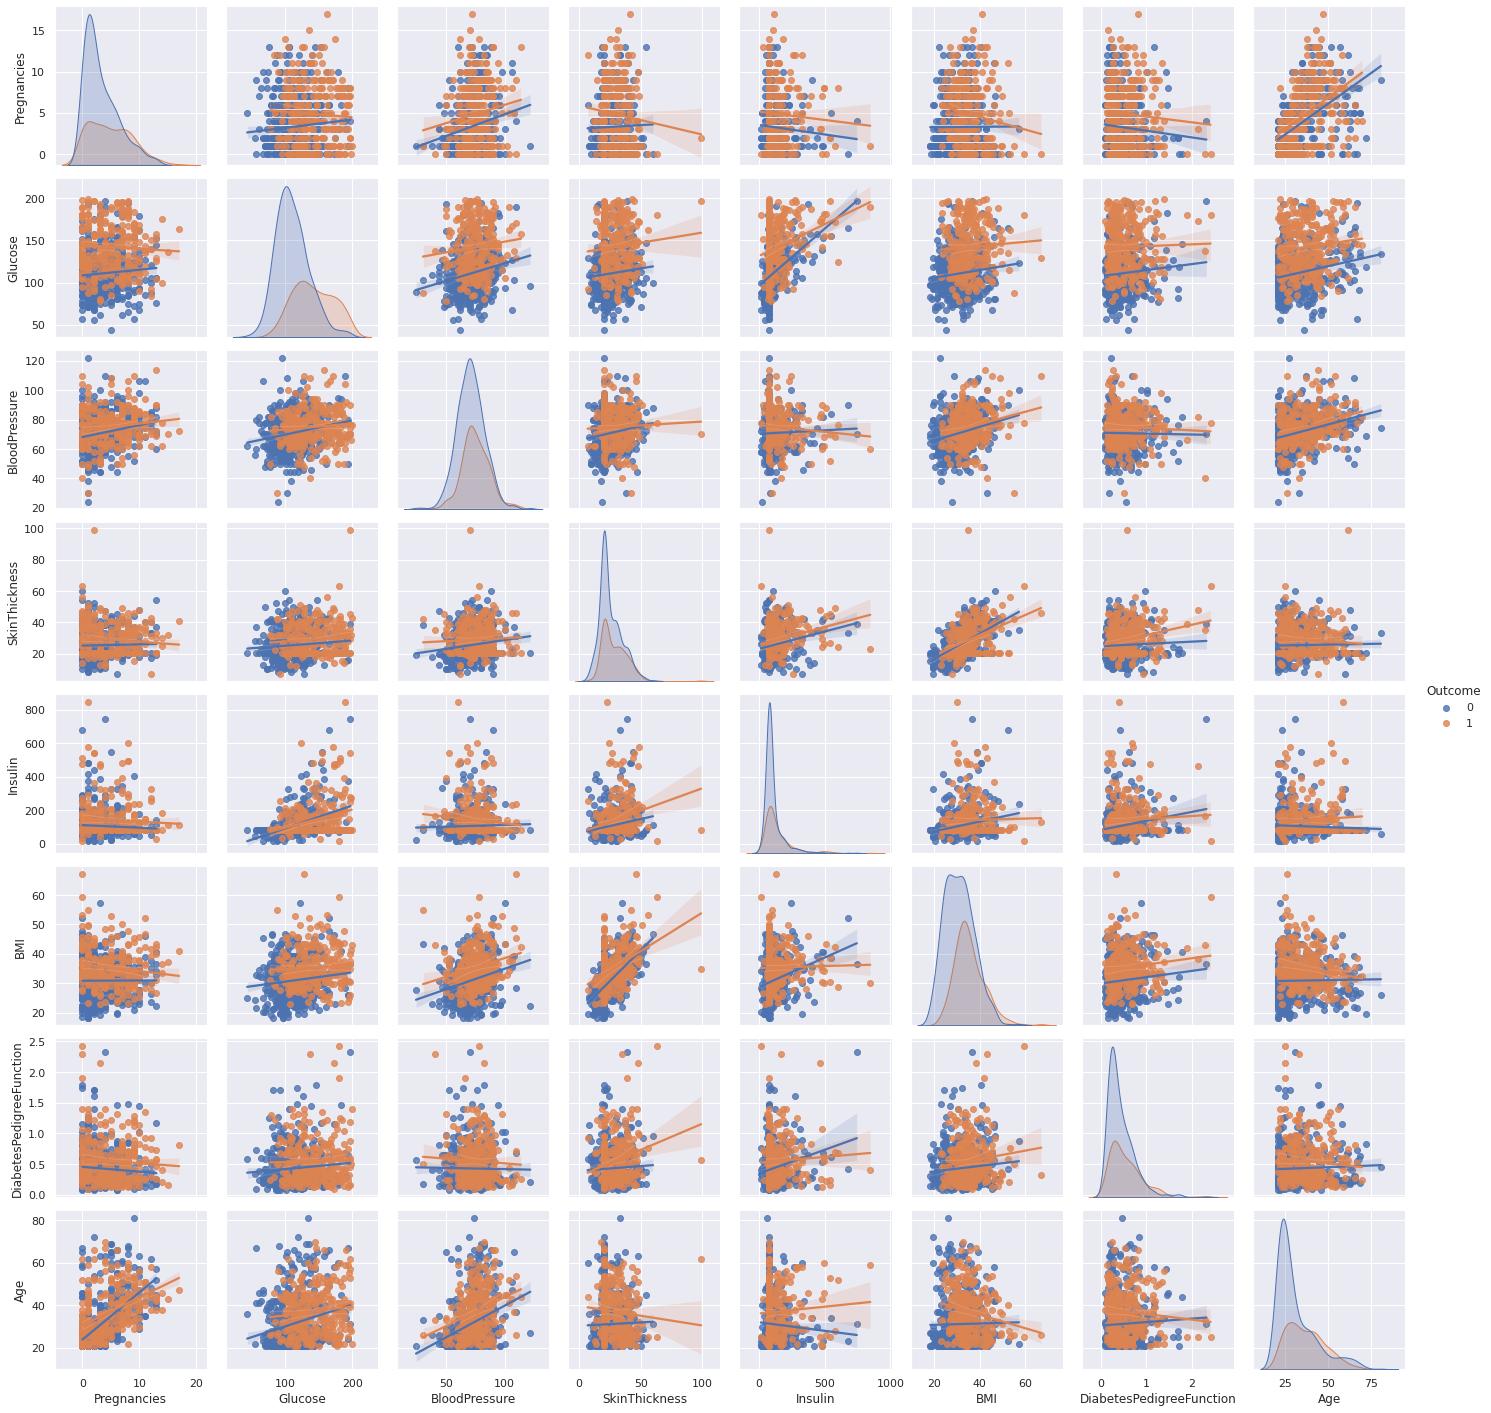

In [ ]:
sns.pairplot(df, kind='reg', hue = 'Outcome')

plt.show()

##### Boxplot

Exceto a glicose, as demais variáveis apresentam outliers.

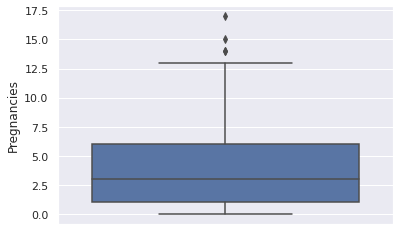

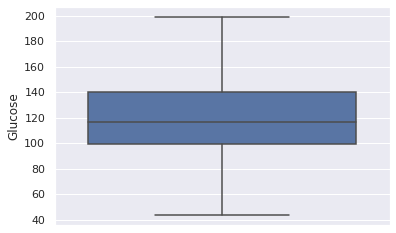

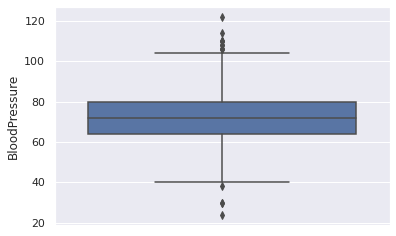

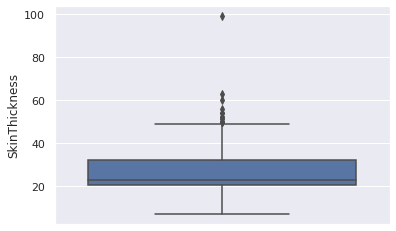

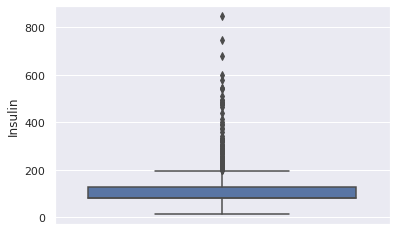

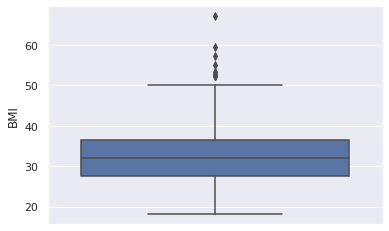

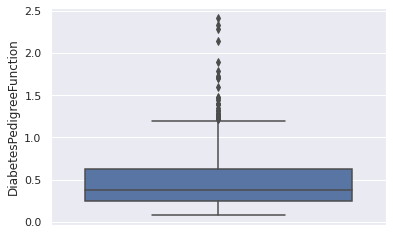

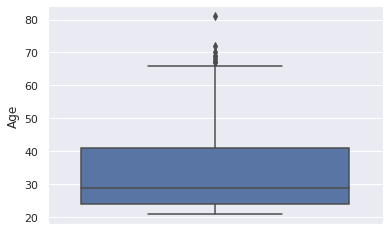

In [ ]:
for i in df.drop('Outcome', axis = 1).columns:
    #sns.boxplot(data = df, x = 'Outcome', y = i)
    sns.boxplot(data = df, y = i)
    plt.show()

#### **2.3.7 Correlações**

Não foram identificadas altas correlações. As variáveis de maior correlação com Outcome são a glicose e índice de massa corporal (BMI).
Outras correlações de destaque são: idade (age) x n° de gravidez (pregnancies) e índice de massa corporal (BMI) x dobras (skinthickness).

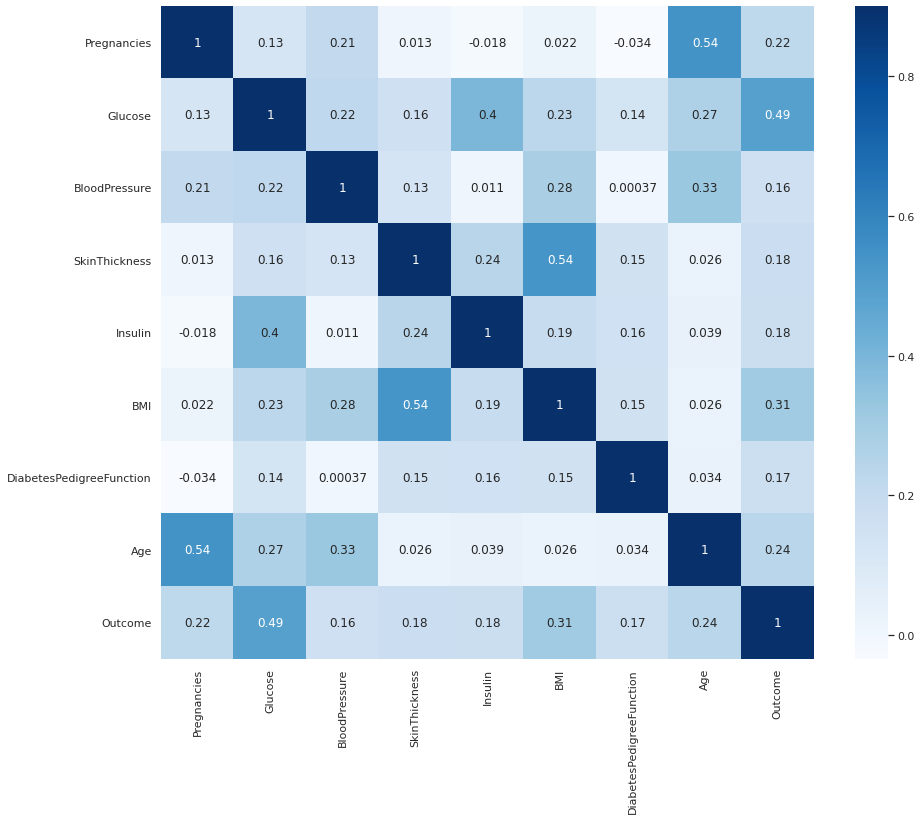

In [ ]:
corr = df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(
    corr,
    vmax=0.9,
    cmap="Blues", square=True, annot = True
)

plt.show()

#### **2.3.8 Análise de Componentes Principais (PCA)**

Traduz dados multidimensionais em bidimensionais com o objetivo de verificar padrões de comportamento.
Verifica-se por exemplo, a separação do resultado de Outcome em dois clusters (diabéticos e não diabéticos).



##### Scale Dataframe

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('Outcome', axis = 1))

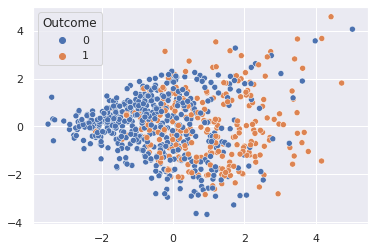

In [ ]:
pca = PCA(n_components = 2)

p = pca.fit_transform(df_scaled)

sns.scatterplot(x = p[:,0], y = p[:,1], hue = df['Outcome'])

plt.show()

##### Verificar peso das variáveis
Observa-se que as variáveis com maior peso são Glicose e Índice de Massa Corporal.

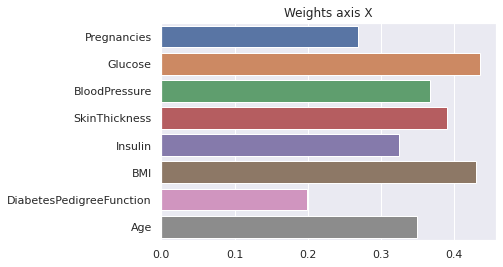

In [ ]:
sns.barplot(x = pca.components_[0], y = df.drop('Outcome', axis = 1).columns)

plt.title('Weights axis X')

plt.show()

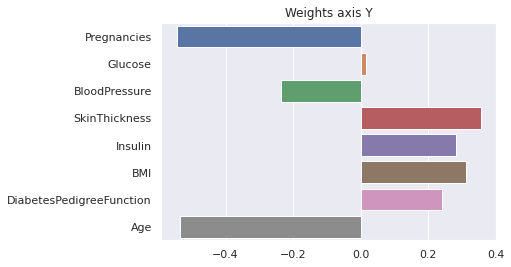

In [ ]:
sns.barplot(x = pca.components_[1], y = df.drop('Outcome', axis = 1).columns)

plt.title('Weights axis Y')

plt.show()

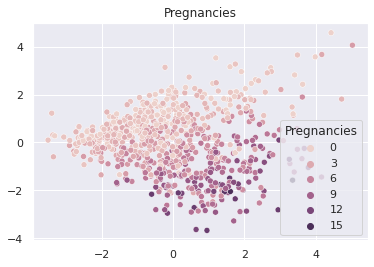

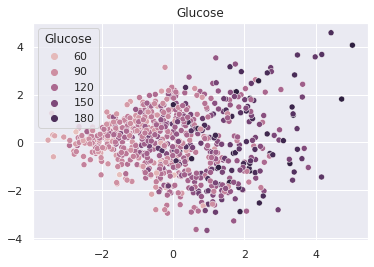

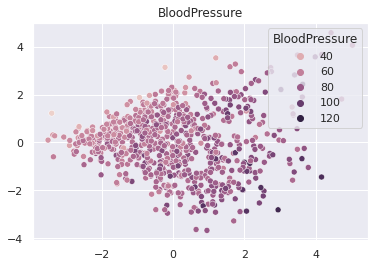

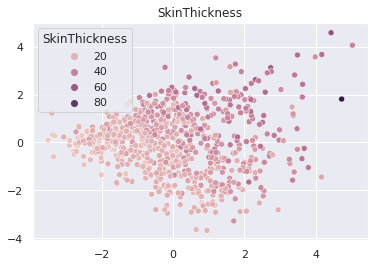

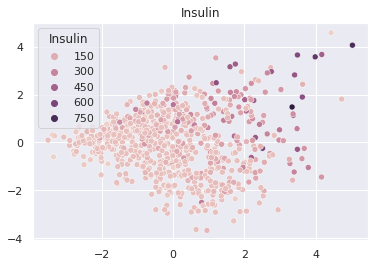

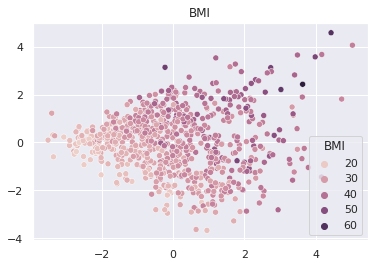

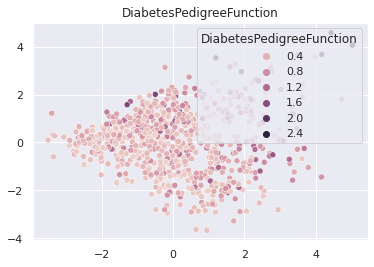

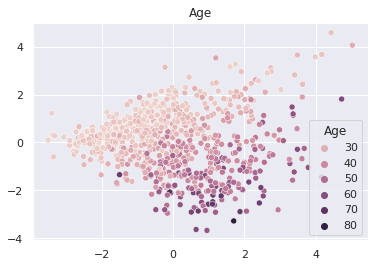

In [ ]:
for i in df.drop('Outcome', axis = 1).columns:
    
    sns.scatterplot(x = p[:,0], y = p[:,1], hue = df[i])
    
    plt.title(i)
    
    plt.show()

##### T-Distributed Stochastic Neighbor Embedding (T-SNE)
Outra forma de reduzir dimensões para facilitar a análise.

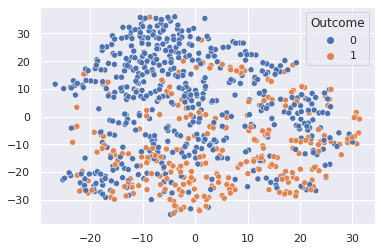

In [ ]:
tsne = TSNE(n_components = 2)

p = tsne.fit_transform(df_scaled)

sns.scatterplot(x = p[:,0], y = p[:,1], hue = df['Outcome'])

plt.show()

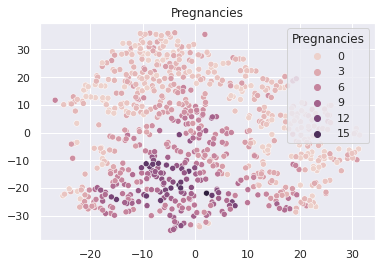

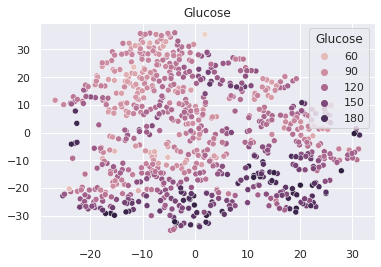

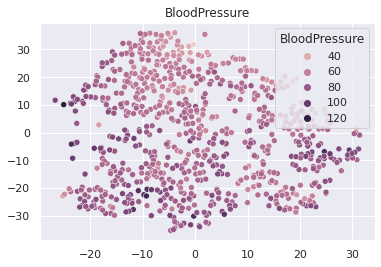

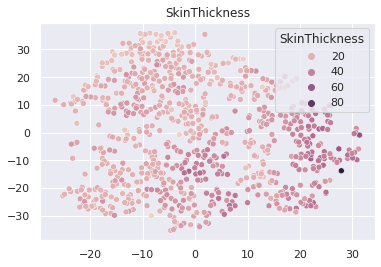

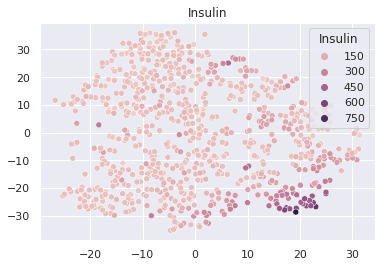

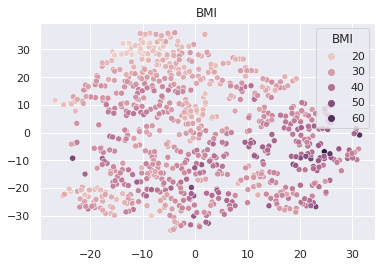

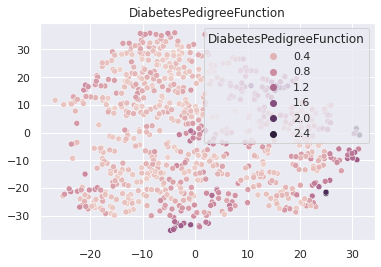

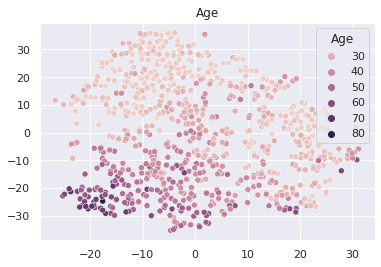

In [ ]:
for i in df.drop('Outcome', axis = 1).columns:
    
    sns.scatterplot(x = p[:,0], y = p[:,1], hue = df[i])
    
    plt.title(i)
    
    plt.show()

##### Predictive Power Score

Medidas de predição por regressão. Verifica-se, por exemplo, que a idade é um bom preditor para número de gravidez.

In [ ]:
pps_matrix = pps.matrix(df)

pps_matrix.query('case != "predict_itself"').sort_values('ppscore', ascending=False).head(20)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
63,Age,Pregnancies,0.239007,regression,True,mean absolute error,2.683594,2.042196,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
7,Pregnancies,Age,0.232018,regression,True,mean absolute error,9.074219,6.968832,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
32,SkinThickness,BMI,0.151415,regression,True,mean absolute error,5.383830,4.568638,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
73,Outcome,Glucose,0.115679,regression,True,mean absolute error,24.249313,21.444173,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
77,Outcome,BMI,0.030716,regression,True,mean absolute error,5.383830,5.218459,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
2,Pregnancies,BloodPressure,0.022064,regression,True,mean absolute error,9.289464,9.084502,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
48,BMI,SkinThickness,0.020628,regression,True,mean absolute error,7.471646,7.317524,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
65,Age,BloodPressure,0.013504,regression,True,mean absolute error,9.289464,9.164023,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
37,Insulin,Glucose,0.013255,regression,True,mean absolute error,24.249313,23.927890,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
5,Pregnancies,BMI,0.012784,regression,True,mean absolute error,5.383830,5.315005,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


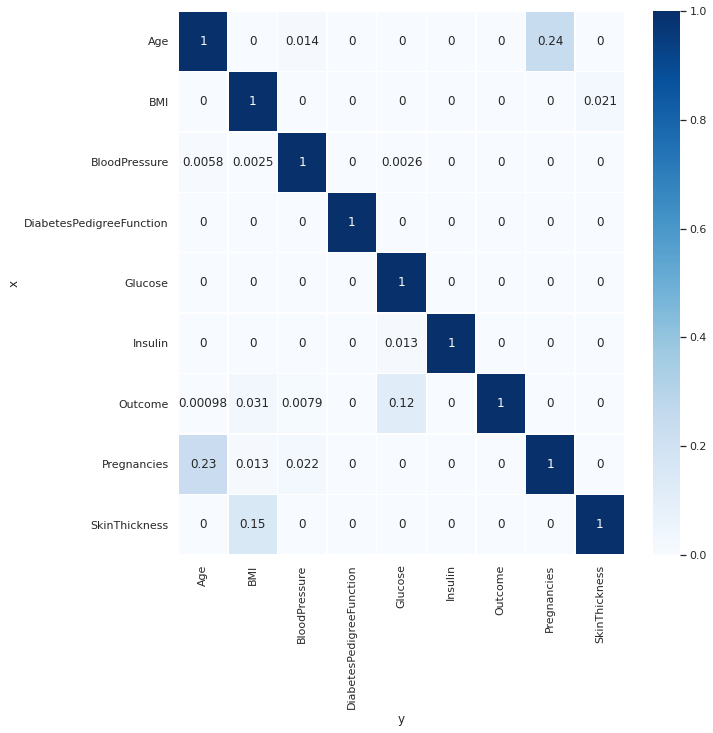

In [ ]:
plt.figure(figsize=(10,10))

sns.heatmap(pps_matrix.pivot(index = 'x', columns = 'y', values = 'ppscore'),
            vmin=0, 
            vmax=1, 
            cmap="Blues", 
            linewidths=0.5, 
            annot=True
           )

plt.show()

## **3) Selecionar conjunto de treino e teste**
Será utilizado o método de Cross-validation, que considera toda a base de dados. Dessa forma, não será utilizada a divisão abaixo.

In [ ]:
# Segregando a variável dependente "Outcome" das variáveis independentes e separando conjunto de treino e teste
features = df.drop('Outcome', axis = 1)
labels = df['Outcome']

In [ ]:
# Padronizando as variáveis
features = StandardScaler().fit_transform(features)

In [ ]:
# Separando parte da amostra para treino e parte para teste
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .2)

## **4) Treinar os modelos**

In [ ]:
# Selecionando alguns métodos para a serem utilizados na modelagem
models = {
    'Logistic Regression': LogisticRegression,
    'Catboost': CatBoostClassifier,
#     'Ridge': RidgeClassifier,
#     'AdaBoost': AdaBoostClassifier,
#     'Bagging': BaggingClassifier,
    'Gradient Boosting': GradientBoostingClassifier,
    'Random Forest': RandomForestClassifier,
    'KNeighborsClassifier': KNeighborsClassifier,
    'LinearSVC': LinearSVC,
    'SGDClassifier': SGDClassifier
}

param_search = {
    'Logistic Regression': {
        'penalty': ["l1", "l2"],
        'C': Real(1e-4, 25.),
        'solver': ['liblinear']
    },
    'Catboost': {
        'iterations': [100],
        'depth':Integer(2,10),
        'learning_rate': Real(.001, 1.0),
        'silent': [True],
        'l2_leaf_reg': Real(.01, 1.0)
        },
#     'Ridge': {
        
#     },
#     'AdaBoost': {
        
#     },
#     'Bagging': {
        
#     },
    'Gradient Boosting': {
        'learning_rate': Real(1e-3, 1.),
        'max_depth': Integer(1, 11),
        'min_samples_split': Integer(2, 21),
        'min_samples_leaf': Integer(1, 21),
        'subsample': Real(0.05, 1.),
        'max_features': Real(0.05, 1.)
    },
    'Random Forest': {
        'criterion': Categorical(["gini", "entropy"]),
        'max_features': Real(.05, 1.),
        'min_samples_split': Integer(2,21),
        'min_samples_leaf':  Integer(1,21),
        'bootstrap': [True, False]
    },
    'KNeighborsClassifier':{
        'n_neighbors': Integer(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },
    'LinearSVC':{
        'penalty': ["l1", "l2"],
        'loss': ["hinge", "squared_hinge"],
        'dual': [True, False],
        'tol': Real(1e-5, 1e-1),
        'C': Real(1e-4, 25.)
    },
    'SGDClassifier':{
        'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['elasticnet'],
        'alpha': Real(0.0, 0.001),
        'learning_rate': ['invscaling', 'constant'],
        'fit_intercept': [True, False],
        'l1_ratio': Real(0.25, 0.5),
        'eta0': Real(0.01, 0.1),
        'power_t': Real(0.5, 50.0)
    }
}

params = {i:{} for i in models}

fit_params = {
    'Logistic Regression': {},
    'Catboost': {'silent':True},
    'Ridge': {},
    'AdaBoost': {},
    'Bagging': {},
    'Gradient Boosting': {},
    'Random Forest': {},
    'KNeighborsClassifier': {},
    'LinearSVC': {},
    'SGDClassifier': {}
}

In [ ]:
%%time
# Testando com os parâmetros padrões
# Remove Warnig messages
warnings.simplefilter('ignore')

cv = KFold(n_splits = 5)

scores = {}

for i in models:
    
    print(f'>> Model: {i}')
    
    score = cross_val_score(models[i](), features, labels, cv = cv, 
                             scoring = 'balanced_accuracy', fit_params = fit_params[i]
                            )
    scores[i] = {'mean': np.mean(score), 'all': score}
    
    print(f'Mean Score: {np.mean(score):.3f}\tSTD: {np.std(score):.3f}\tScores: {score}\n')
    
warnings.simplefilter('default')

>> Model: Logistic Regression
Mean Score: 0.720	STD: 0.023	Scores: [0.70351852 0.69565972 0.73946464 0.75506073 0.70875421]

>> Model: Catboost
Mean Score: 0.735	STD: 0.035	Scores: [0.7162963  0.71805556 0.73792729 0.80161943 0.7020202 ]

>> Model: Gradient Boosting
Mean Score: 0.726	STD: 0.023	Scores: [0.74481481 0.68350694 0.72400072 0.74595142 0.73063973]

>> Model: Random Forest
Mean Score: 0.732	STD: 0.037	Scores: [0.7062963  0.70017361 0.73946464 0.80161943 0.71127946]

>> Model: KNeighborsClassifier
Mean Score: 0.722	STD: 0.024	Scores: [0.71203704 0.69461806 0.72246337 0.7668691  0.71464646]

>> Model: LinearSVC
Mean Score: 0.720	STD: 0.022	Scores: [0.70851852 0.69010417 0.73069271 0.75506073 0.71801347]

>> Model: SGDClassifier
Mean Score: 0.667	STD: 0.045	Scores: [0.5937037  0.70121528 0.72400072 0.66363023 0.65319865]

CPU times: user 15 s, sys: 1.13 s, total: 16.1 s
Wall time: 10.6 s


In [ ]:
%%time
## Atenção: Tempo elevado necessário para o processamento desta seção
# Calculo e Ajuste para definições dos melhores valores de parâmetros a serem aplicados nos métodos
# Remove Warnig messages
warnings.simplefilter('ignore')

cv = KFold(n_splits = 5)

for i in tqdm.tqdm(models):

    searcher = BayesSearchCV(
        estimator = models[i](), 
        search_spaces = param_search[i], 
        error_score = 0, n_iter = 50, cv = cv
    )

    searcher.fit(features, labels)

    params[i] = searcher.best_params_
    
warnings.simplefilter('default')

100%|██████████| 7/7 [12:33<00:00, 107.58s/it]

CPU times: user 14min 38s, sys: 5min 29s, total: 20min 8s
Wall time: 12min 33s


In [ ]:
# Salvando/Armazenado os parâmetros otimizados na etapa anterior para utilizações futuras
with open('params.json', 'w') as f:
    json.dump(params, f, indent = 4)

In [ ]:
# Carregando os parâmetros otimizados e salvos em arquivo conforme etapa anterior
with open('params.json', 'r') as f:
    params = json.load(f)

In [ ]:
%%time
# Aplicando os valores dos parâmetros otimizados e salvos nas etapas anteriores nos diversos métodos 

cv = KFold(n_splits = 5)

scores = {}

for i in models:
    
    print(f'>> Model: {i}')
    
    score = cross_val_score(models[i](** params[i]), features, labels, cv = cv, 
                             scoring = 'balanced_accuracy', fit_params = fit_params[i]
                            )
    scores[i] = {'mean': np.mean(score), 'all': score}
    
    print(f'Mean Score: {np.mean(score):.3f}\tScores: {score}\n')

>> Model: Logistic Regression
Mean Score: 0.721	Scores: [0.71277778 0.68784722 0.73946464 0.75506073 0.70875421]

>> Model: Catboost
Mean Score: 0.715	Scores: [0.70203704 0.6578125  0.73277265 0.7891363  0.69276094]

>> Model: Gradient Boosting
Mean Score: 0.720	Scores: [0.7312963  0.66996528 0.7373847  0.7462888  0.71717172]

>> Model: Random Forest
Mean Score: 0.716	Scores: [0.68777778 0.66006944 0.72707542 0.7891363  0.71632997]

>> Model: KNeighborsClassifier
Mean Score: 0.710	Scores: [0.72351852 0.62309028 0.71260626 0.80195682 0.69107744]

>> Model: LinearSVC
Mean Score: 0.734	Scores: [0.73277778 0.70572917 0.72707542 0.76788124 0.73653199]

>> Model: SGDClassifier
Mean Score: 0.722	Scores: [0.70851852 0.70017361 0.73277265 0.77226721 0.6952862 ]

CPU times: user 3.22 s, sys: 157 ms, total: 3.37 s
Wall time: 2.99 s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

## **5) Avaliar os modelos**

### **5.1 - Avaliar os modelos individualmente**

In [ ]:
# Realizando as predições utilizando os modelos calculados, com parâmetros otimizados, nas etapas anteriores
# Selecionado o método de cross-validation para a predição por ser considerado como um método mais amplo na forma de 
# trabalhar com a base de dados. Desta forma podemos desconsiderar a parte de treino e teste realizadas no início deste documento.

predictions = {}

for i in models:
    predictions[i] = cross_val_predict(models[i](** fit_params[i]), features, labels, method = 'predict')

predictions_df = pd.DataFrame(predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

>>>> Model: Logistic Regression


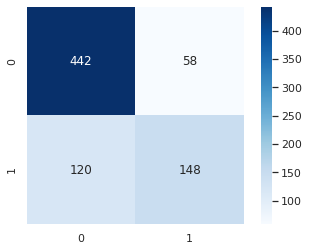

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.72      0.55      0.62       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768

>>>> Model: Catboost


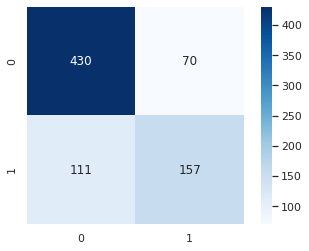

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       500
           1       0.69      0.59      0.63       268

    accuracy                           0.76       768
   macro avg       0.74      0.72      0.73       768
weighted avg       0.76      0.76      0.76       768

>>>> Model: Gradient Boosting


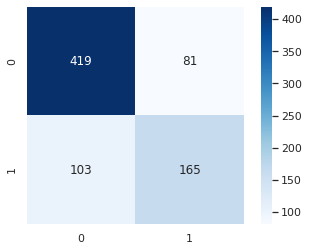

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       500
           1       0.67      0.62      0.64       268

    accuracy                           0.76       768
   macro avg       0.74      0.73      0.73       768
weighted avg       0.76      0.76      0.76       768

>>>> Model: Random Forest


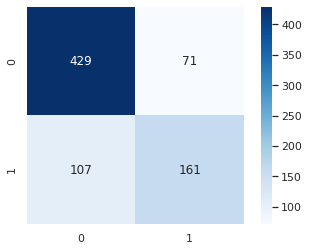

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       500
           1       0.69      0.60      0.64       268

    accuracy                           0.77       768
   macro avg       0.75      0.73      0.74       768
weighted avg       0.76      0.77      0.76       768

>>>> Model: KNeighborsClassifier


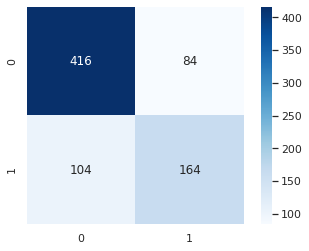

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       500
           1       0.66      0.61      0.64       268

    accuracy                           0.76       768
   macro avg       0.73      0.72      0.73       768
weighted avg       0.75      0.76      0.75       768

>>>> Model: LinearSVC


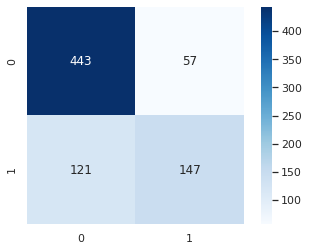

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       500
           1       0.72      0.55      0.62       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768

>>>> Model: SGDClassifier


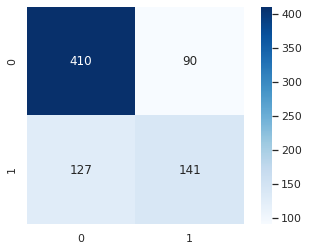

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       500
           1       0.61      0.53      0.57       268

    accuracy                           0.72       768
   macro avg       0.69      0.67      0.68       768
weighted avg       0.71      0.72      0.71       768



In [ ]:
# Apresentando a matriz confusão, assim como os respectivos índices, para cada predição calculada na etapa anterior
for i in predictions_df.columns:
    print(f'>>>> Model: {i}')
    
    sns.heatmap(
        confusion_matrix(labels, predictions_df[i]),
        cmap="Blues", square=True, annot = True, fmt = '.0f'
    )

    plt.show()

    print(classification_report(labels, predictions_df[i]))

In [ ]:
predictions_prob = {}

for i in models:
    try:
        predictions_prob[i] = cross_val_predict(models[i](** fit_params[i]), features, labels, method = 'predict_proba')
    except:
        pass

predictions_prov_df = pd.DataFrame({i: predictions_prob[i][:,1] for i in predictions_prob})

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Apresentação do índice AUC de cada modelo
cols = predictions_prov_df.columns

roc_scores = pd.DataFrame([
    roc_auc_score(labels, predictions_df[i])
    for i in cols
    
], index = cols)

roc_scores

,0
Logistic Regression,0.718119
Catboost,0.722910
Gradient Boosting,0.726836
Random Forest,0.729373
KNeighborsClassifier,0.721970


### **5.2 - Avaliar o modelo com Predição consolidado pela média de todos os modelos preditivos calculados nas etapas anteriores.**

Combinando os modelos preditivos, diminuindo a variância e fazendo um modelo mais completo. Neste caso, como é um modelo logístico, e não de regressão, pode se fazer a média das probabilidades ou fazer um voto para cada modelo. 

In [ ]:
#Calcula o Índice AUC considerando as médias de todos os métodos de predição utilizados/apresentados nas etapas anteriores
roc_auc_score(labels, predictions_df.mean(axis = 1))

0.8017014925373134

Juntando os modelos pela média das variâncias. 
Ele calculando a média, se o resultado for maior que 0.5, nota 1 se for menor que 0.5,nota 0.

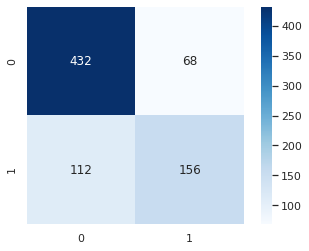

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       500
           1       0.70      0.58      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768



In [ ]:
# Apresenta a matriz confusão e índices finais consolidados, isto considerando as médias das predições anteriores.
pred_mean = predictions_df.mean(axis = 1).apply(lambda f: 1 if f >= .5 else 0)

sns.heatmap(
    confusion_matrix(labels, pred_mean),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

print(classification_report(labels, pred_mean))

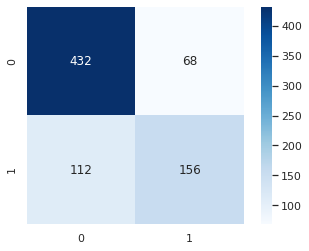

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       500
           1       0.70      0.58      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768



In [ ]:
# Mesma apresentação do ítem anterior porém aplicanto o conceito de vote (voto) para a confecção/apresentação da matriz confusão
# e respectivos índices
pred_vote = predictions_df.mean(axis = 1).apply(lambda f: 1 if f >= .5 else 0)

sns.heatmap(
    confusion_matrix(labels, pred_vote),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

print(classification_report(labels, pred_vote))

### **5.3 - Avaliar o modelo preditivo definido por meio de ferramenta automatizada de Machine Learning.**

In [ ]:
## Atenção: Tempo elevado necessário para o processamento desta seção
# Procura o melhor modelo aplicando método de Machine Learning. Devido a complexidade da análise, a execução é demorada.
tpot = TPOTClassifier(scoring = 'balanced_accuracy', 
                     max_time_mins = 480, 
                     n_jobs = -1,
                     verbosity = 2,
                     cv = 5,
                     early_stop = 5
                     )

tp_fit = tpot.fit(features, labels)

tpot.export('diabetes_pipeline.py')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectFwe, VarianceThreshold, f_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

# Average CV score on the training set was: 0.7709182389937107
tpot_pipeline = make_pipeline(
    PCA(iterated_power=6, svd_solver="randomized"),
    SelectFwe(score_func=f_classif, alpha=0.034),
    VarianceThreshold(threshold=0.0005),
    MaxAbsScaler(),
    FastICA(tol=0.8),
    SGDClassifier(alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=1.0, learning_rate="invscaling", loss="hinge", penalty="elasticnet", power_t=0.5)
)

In [ ]:

score = cross_val_score(tpot_pipeline, features, labels, cv = cv, 
                         scoring = 'balanced_accuracy', fit_params = fit_params[i]
                        )
scores[i] = {'mean': np.mean(score), 'all': score}

print(f'Mean Score: {np.mean(score):.3f}\tScores: {score}\n')

Mean Score: 0.728	Scores: [0.72462963 0.69618056 0.72716585 0.77867746 0.71464646]



Resultado do melhor modelo encontrado pelo Machine Learning

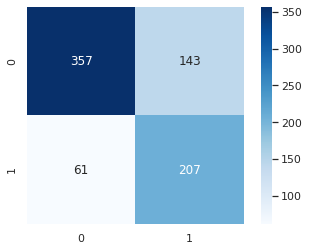

              precision    recall  f1-score   support

           0       0.85      0.71      0.78       500
           1       0.59      0.77      0.67       268

    accuracy                           0.73       768
   macro avg       0.72      0.74      0.72       768
weighted avg       0.76      0.73      0.74       768



In [ ]:
# Apresentando a matriz confusão, assim como os respectivos índices
pred = cross_val_predict(tpot_pipeline, features, labels)

sns.heatmap(
    confusion_matrix(labels, pred),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

print(classification_report(labels, pred))

## **6) - Definir o modelo mais robusto**

### **6.1 - Conclusão**
Considerando da consolidação de todos os modelos aplicados nas etapas acima e analisando os resuldados das matrizes confusão e os respectivos índices, podemos indicar o modelo "Gradiente Boosting" como o mais robusto e, dessa forma, o mais adequado/indicado para ser utilizado. 

#### **6.1.1 Matriz confusão**

C:\Users\Teodoro\Anaconda3\lib\site-packages\matplotlib\colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


Modelo: Gradient Boosting


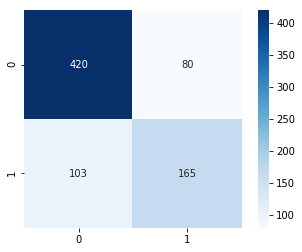

In [ ]:
sns.heatmap(confusion_matrix(labels, predictions_df['Gradient Boosting']),cmap="Blues", square=True, annot = True, fmt = '.0f')
print('Modelo: Gradient Boosting')
plt.show()

A segunda linha é para pacientes cujo valor real de Diabetes é 1 (considerando toda a base de dados pois foi calculado através de "Cross-validation"). Conforme o cálculo do modelo, em 768 pacientes, o valor de Diabetes de 268 deles é 1. E desses 268, o classificador previu corretamente 165 deles como 1 e 420 deles como 0.

Isso significa que, para 165 clientes, o valor real de Diabetes era 1 na base de dados e o classificador também previu corretamente como 1. No entanto, enquanto o real de 103 clientes era classe 1, o classificador previu como 0, o que não é muito bom. Podemos considerá-lo como erro do modelo para a segunda linha.

E os clientes com valor de Diabetes igual a 0? Vamos olhar para a primeira linha. Havia 500 clientes cujo valor de Diabetes era 0.

O classificador previu corretamente 420 deles como classe 0 e 80 deles incorretamente como classe 1. Portanto, podemos considerar que o modelo apresentou uma previsão considerável para os clientes com valor de Diabetes igual a 0.

Uma coisa boa sobre a matriz de confusão é que mostra a capacidade do modelo de prever corretamente ou separar as classes. Em casos específicos de classificador binário, como este exemplo, podemos interpretar esses números como a contagem de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.

#### **6.1.2 Índices (accuracy, precision, f1-score,...)**

In [ ]:
print('Modelo: Gradient Boosting - Índices')
print(classification_report(labels, predictions_df['Gradient Boosting']))

Modelo: Gradient Boosting - Índices
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       500
           1       0.67      0.62      0.64       268

    accuracy                           0.76       768
   macro avg       0.74      0.73      0.73       768
weighted avg       0.76      0.76      0.76       768



#### **6.1.3 - Índice AUC**

In [ ]:
print('Modelo: Gradient Boosting - AUC')
roc_auc_score(labels, predictions_df['Gradient Boosting'])

Modelo: Gradient Boosting - AUC


0.7278358208955223

# FIM